In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [2]:
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')

train.describe()

train.head()

id Product ID Type  Air temperature [K]  Process temperature [K]  \
0   0     L50096    L                300.6                    309.6   
1   1     M20343    M                302.6                    312.1   
2   2     L49454    L                299.3                    308.5   
3   3     L53355    L                301.0                    310.9   
4   4     M24050    M                298.0                    309.0   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1596         36.1              140                0    0   
1                    1759         29.1              200                0    0   
2                    1805         26.5               25                0    0   
3                    1524         44.3              197                0    0   
4                    1641         35.4               34                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [3]:
#print(train.columns, train.dtypes)
num_cols = ['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']
bin_cols = ['TWF', 'HDF', 'PWF', 'OSF','RNF']
cat_cols = ['Type']
target_cols = ['Machine failure']

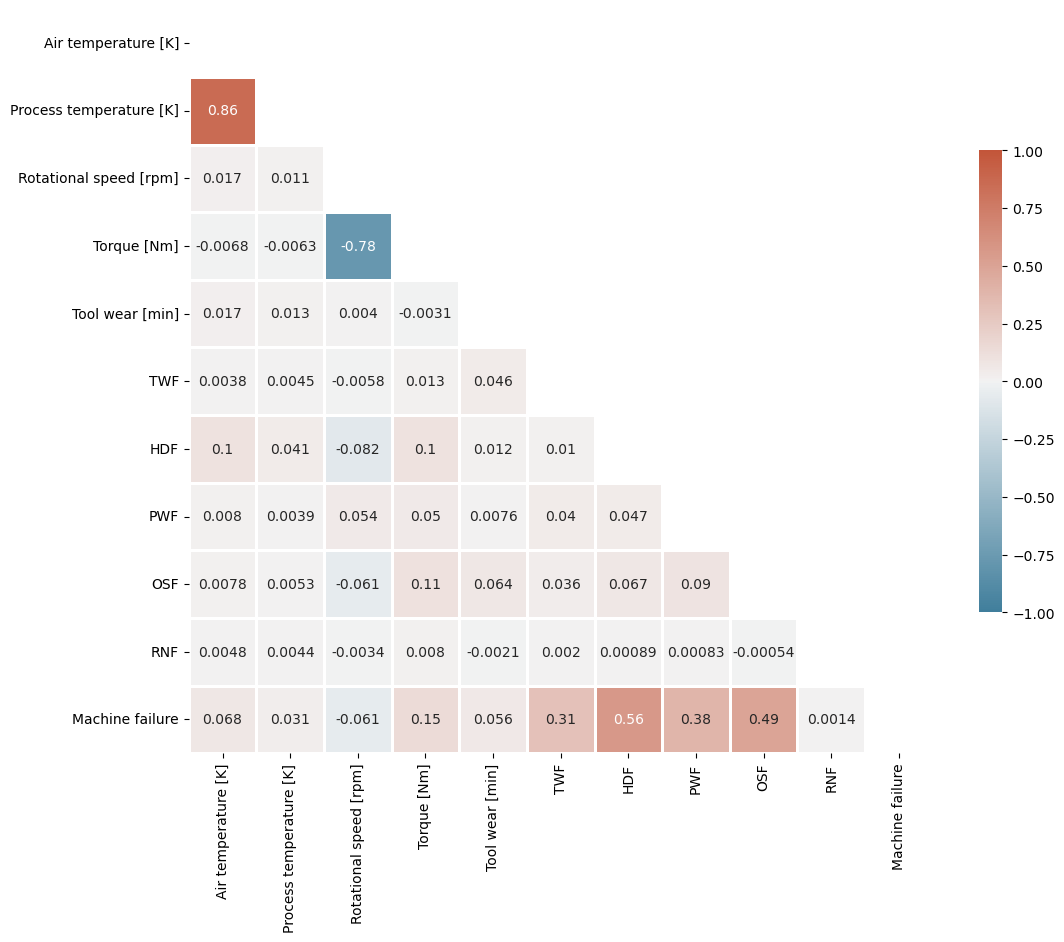

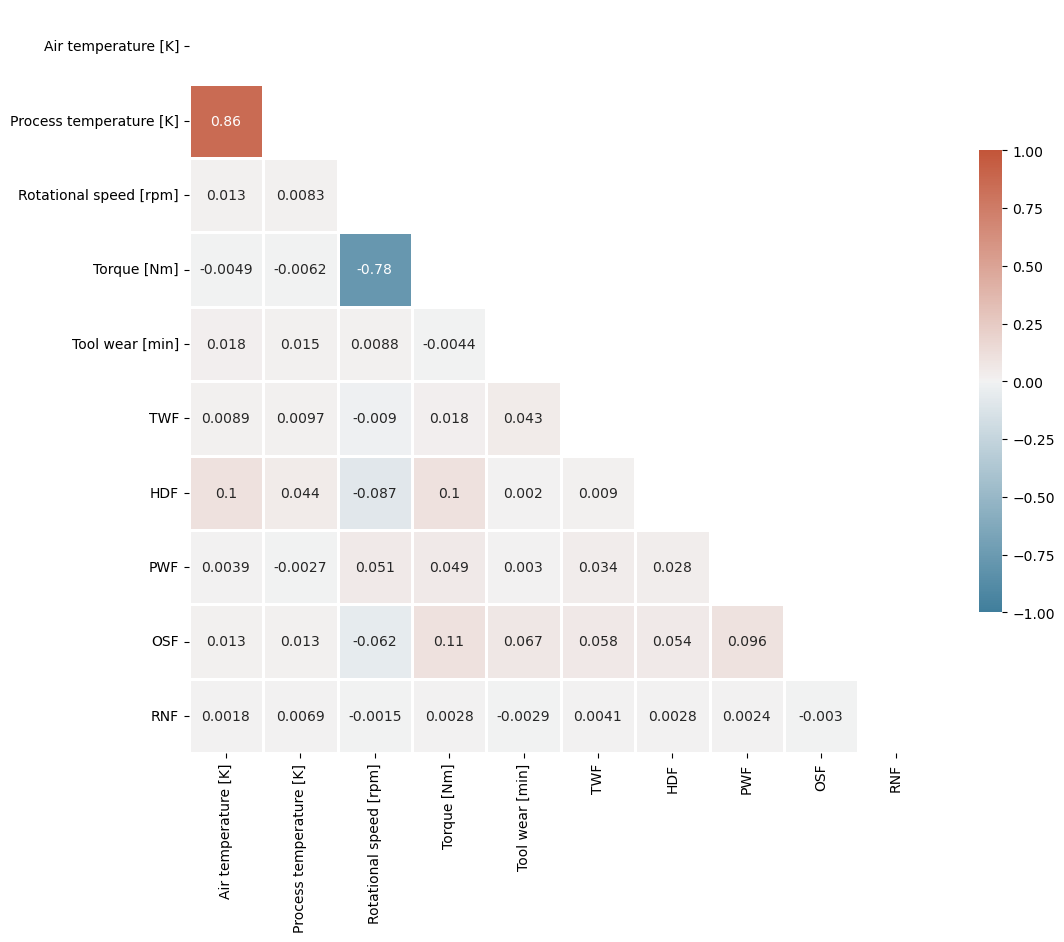

In [4]:
import seaborn as sns
import matplotlib.pyplot as plot

def plot_corr(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f,ax = plot.subplots(figsize = (12,12))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr,mask=mask,cmap=cmap, vmax=1,vmin=-1, center=0,
                square=True, linewidths=1, cbar_kws={"shrink": .5}, annot =True)
plot_corr(train[num_cols + bin_cols + target_cols])
plot_corr(test[num_cols + bin_cols])

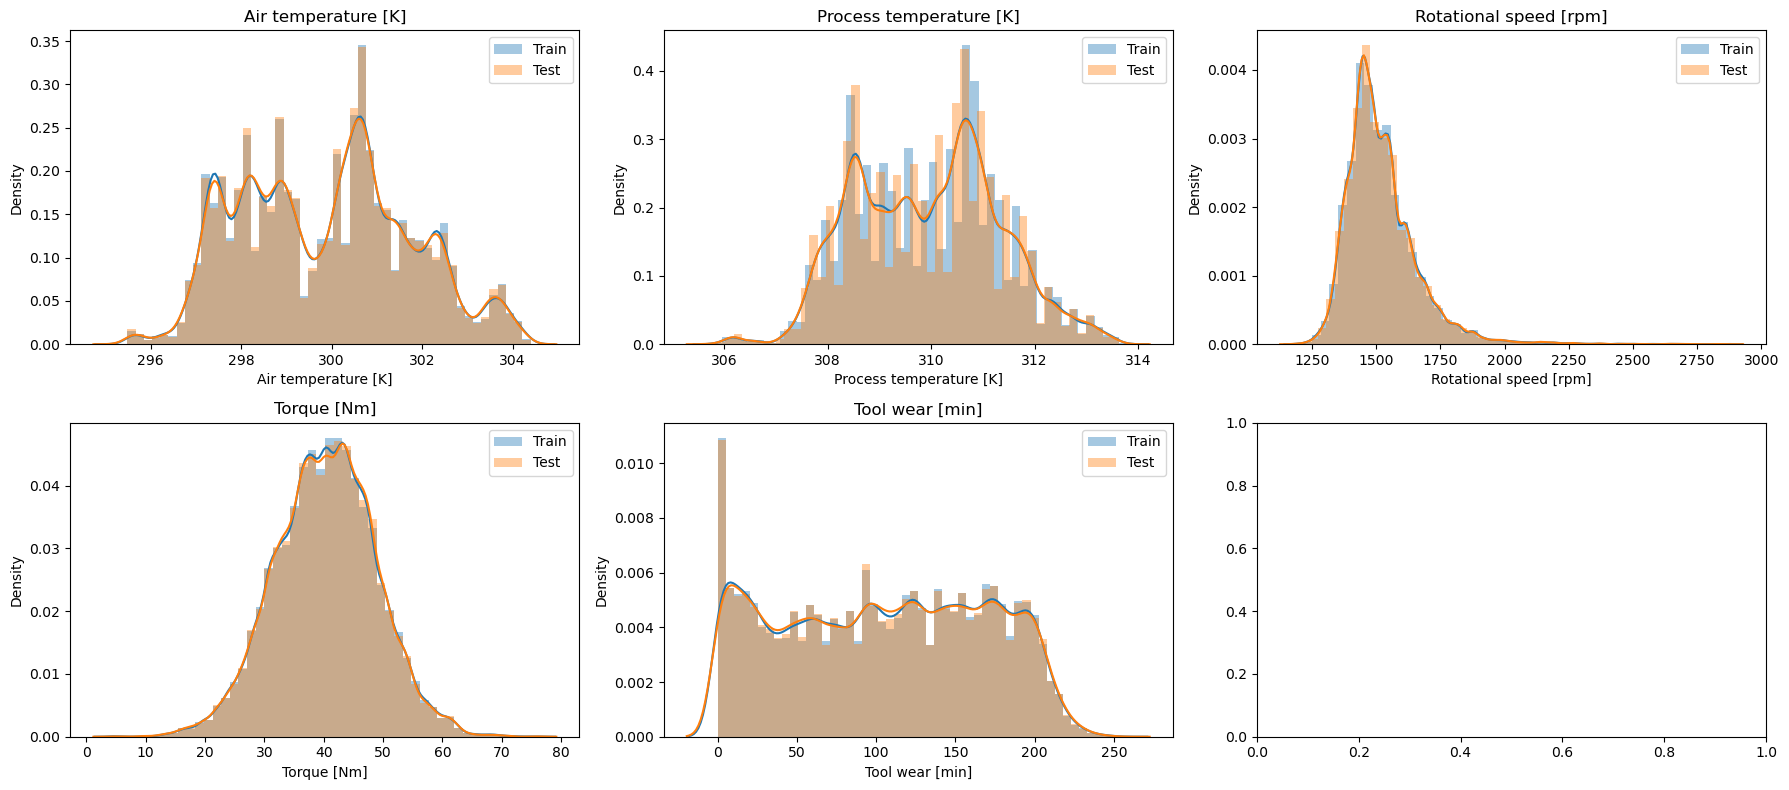

In [5]:
def plot_dist(data_train,data_test,n_cols):
    fig, axes = plot.subplots(nrows = 2, ncols= n_cols,figsize = (18,8))
    axes = axes.flatten()
    
    for i, var_name in enumerate(data_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(data_train[var_name],kde = 'True', ax = ax, label = 'Train')
        sns.distplot(data_test[var_name],kde = 'True', ax = ax, label = 'Test')
        ax.set_title(f'{var_name}')
        ax.legend()
    plot.tight_layout()
    plot.show()
    
plot_dist(train[num_cols],test[num_cols],3)

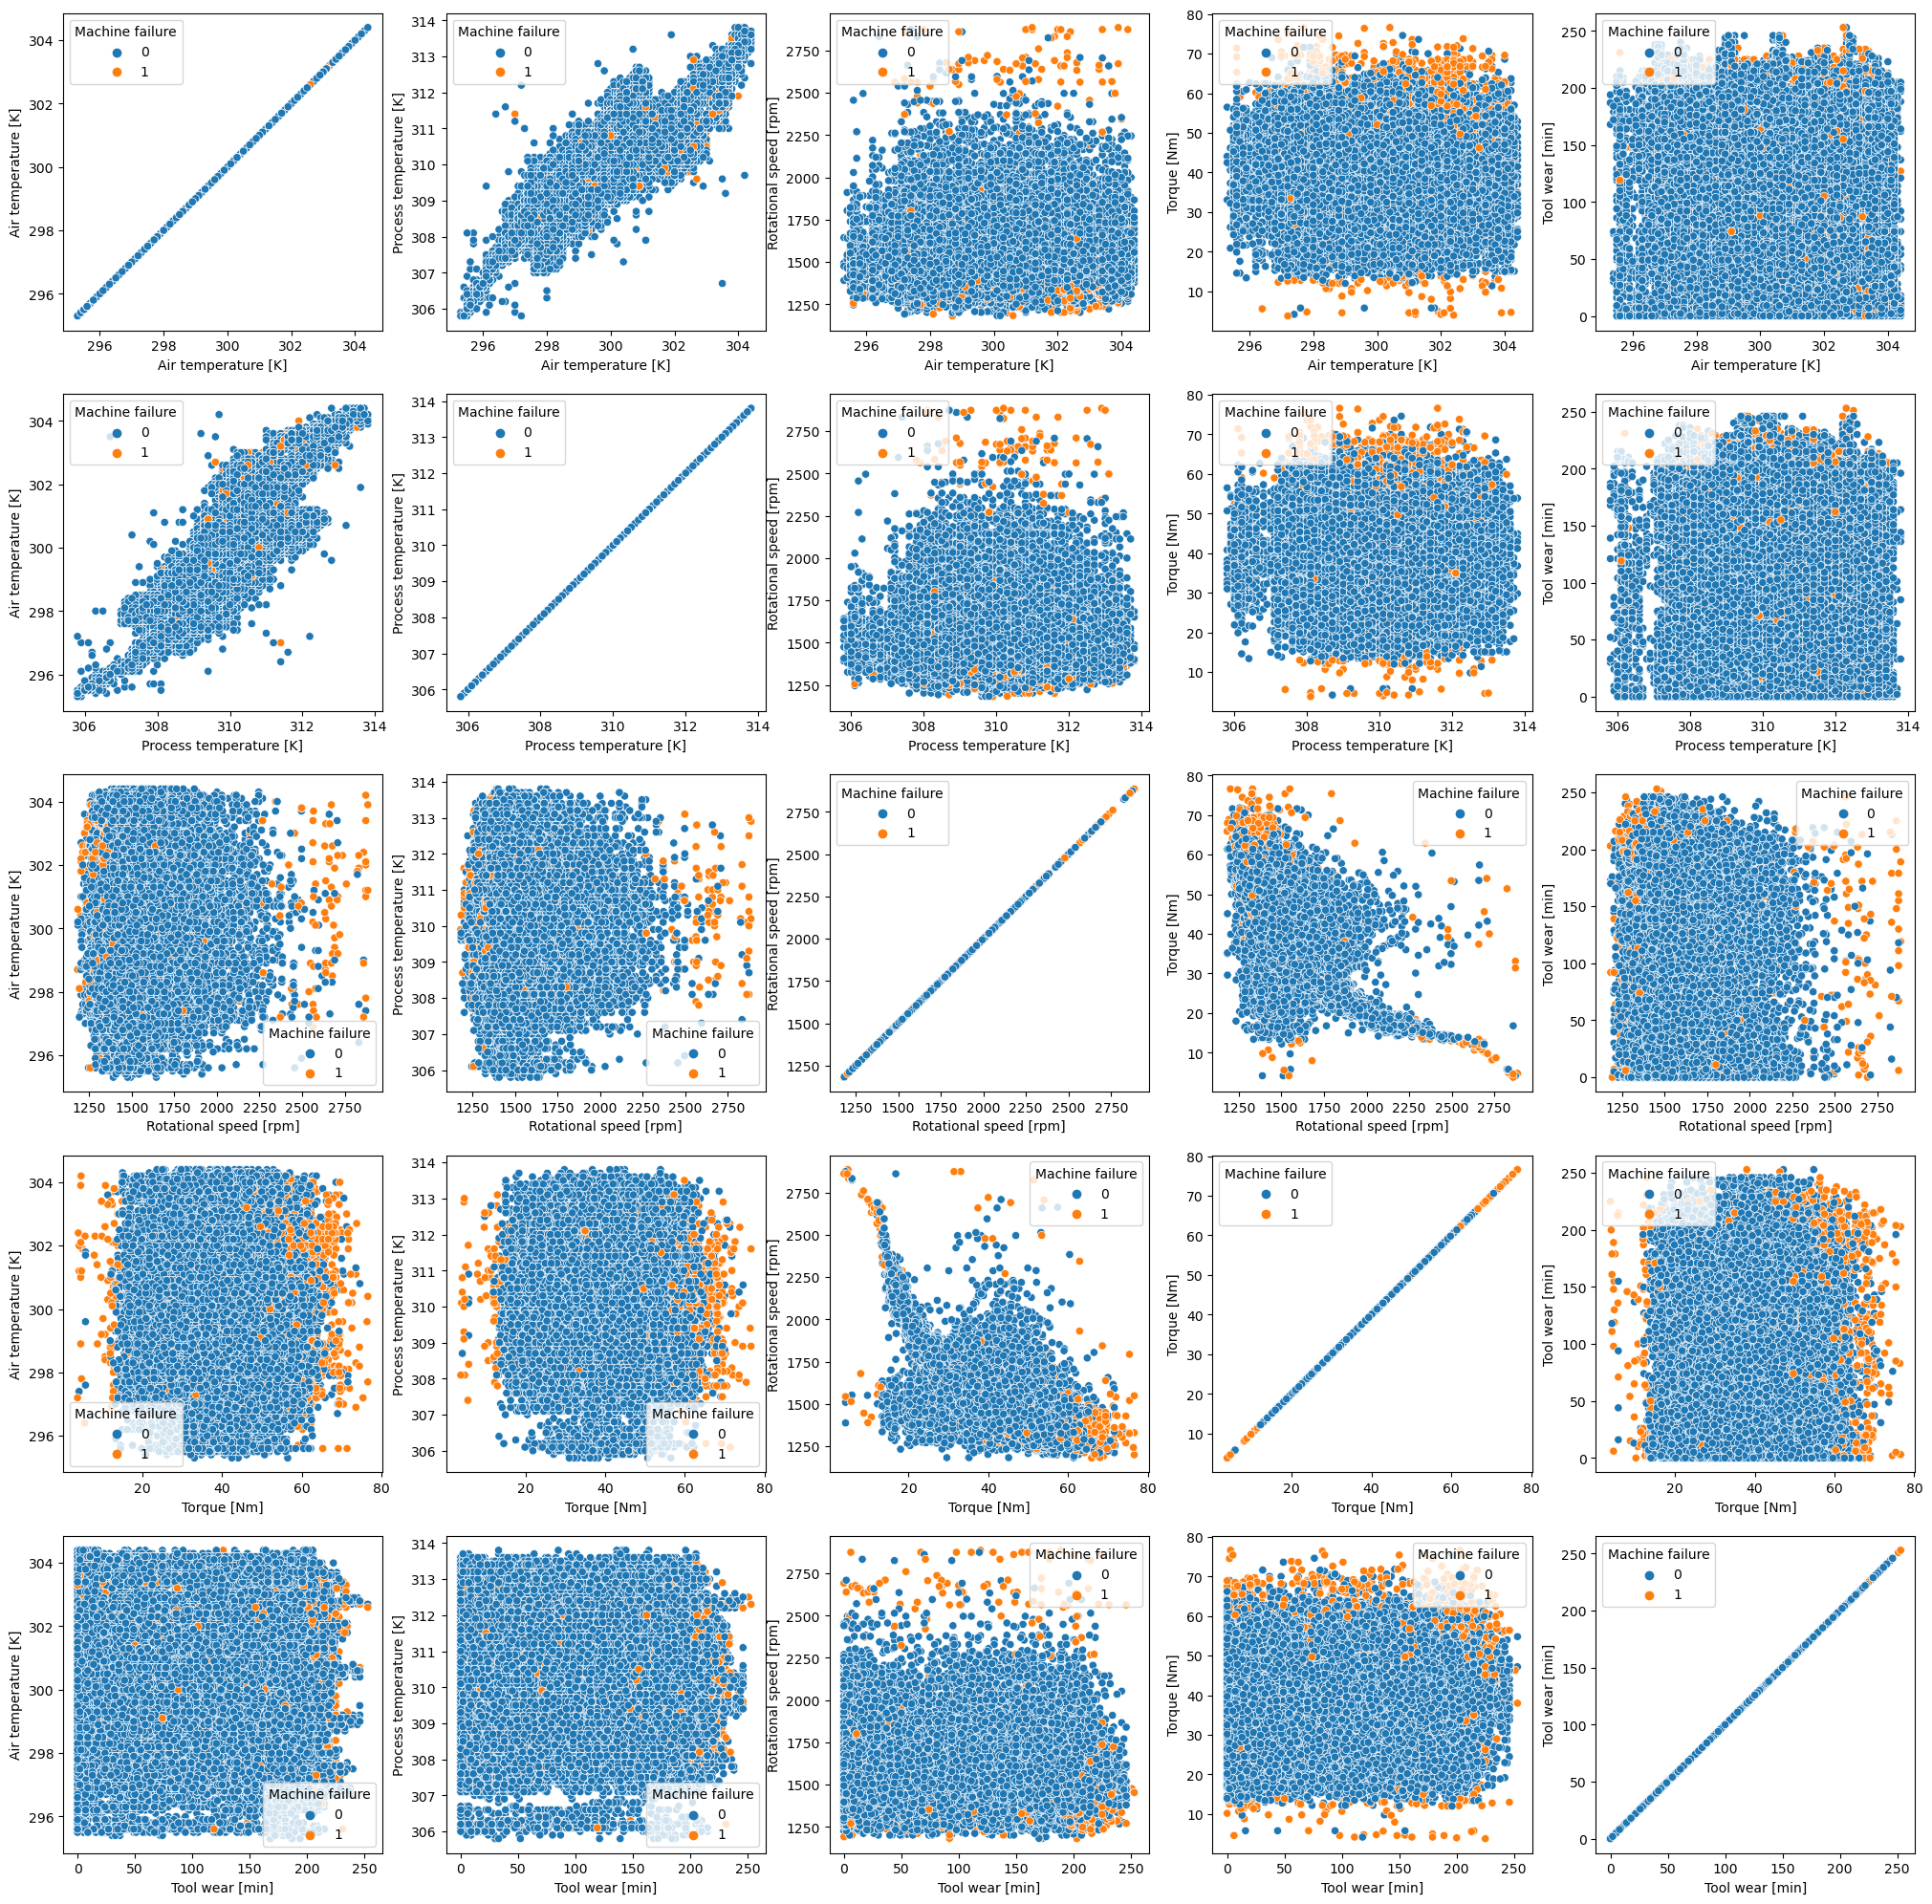

In [6]:
def plot_scatter(data,cols,target_col):
    dim = len(cols)
    fig, axes = plot.subplots(ncols=dim,nrows=dim,figsize=(25,25))
    
    for i,x in enumerate(cols):
        for j,y in enumerate(cols):
            sns.scatterplot(data,x=x,y=y, hue = target_col,ax=axes[i,j])
            
    plot.show()
    
plot_scatter(train,num_cols,target_cols[0])

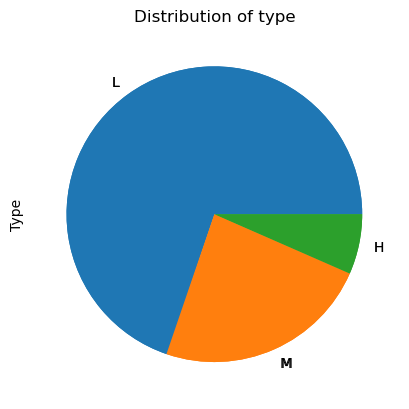

In [7]:
def plot_pie_dist(data,col_name):
    plt_data = data[col_name].value_counts()
    
    plt_data.plot.pie(title="Distribution of type")
  
    
plot_pie_dist(train,"Type")
plot_pie_dist(test,"Type")


In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

def one_hot_encode(data):
    col_name =data['Type'].unique()
    for c in cat_cols:
        cats = data[c].unique()
        for i,cat in enumerate(cats):
            data[c] = data[c].replace({cat:i+1})
        data[c] = data[c].astype(int)
        
    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    data_encoded = pd.DataFrame(data = enc.fit_transform(data[cat_cols]).astype(int),columns = col_name  )

    data = pd.concat([data,data_encoded],axis =1 )
    data.drop(cat_cols,inplace = True, axis=1)
    return data
    

trans_train = one_hot_encode(train)
print(trans_train.head())

   id Product ID  Air temperature [K]  Process temperature [K]  \
0   0     L50096                300.6                    309.6   
1   1     M20343                302.6                    312.1   
2   2     L49454                299.3                    308.5   
3   3     L53355                301.0                    310.9   
4   4     M24050                298.0                    309.0   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1596         36.1              140                0    0   
1                    1759         29.1              200                0    0   
2                    1805         26.5               25                0    0   
3                    1524         44.3              197                0    0   
4                    1641         35.4               34                0    0   

   HDF  PWF  OSF  RNF  L  M  H  
0    0    0    0    0  1  0  0  
1    0    0    0    0  0  1  0  
2    0    0    0 

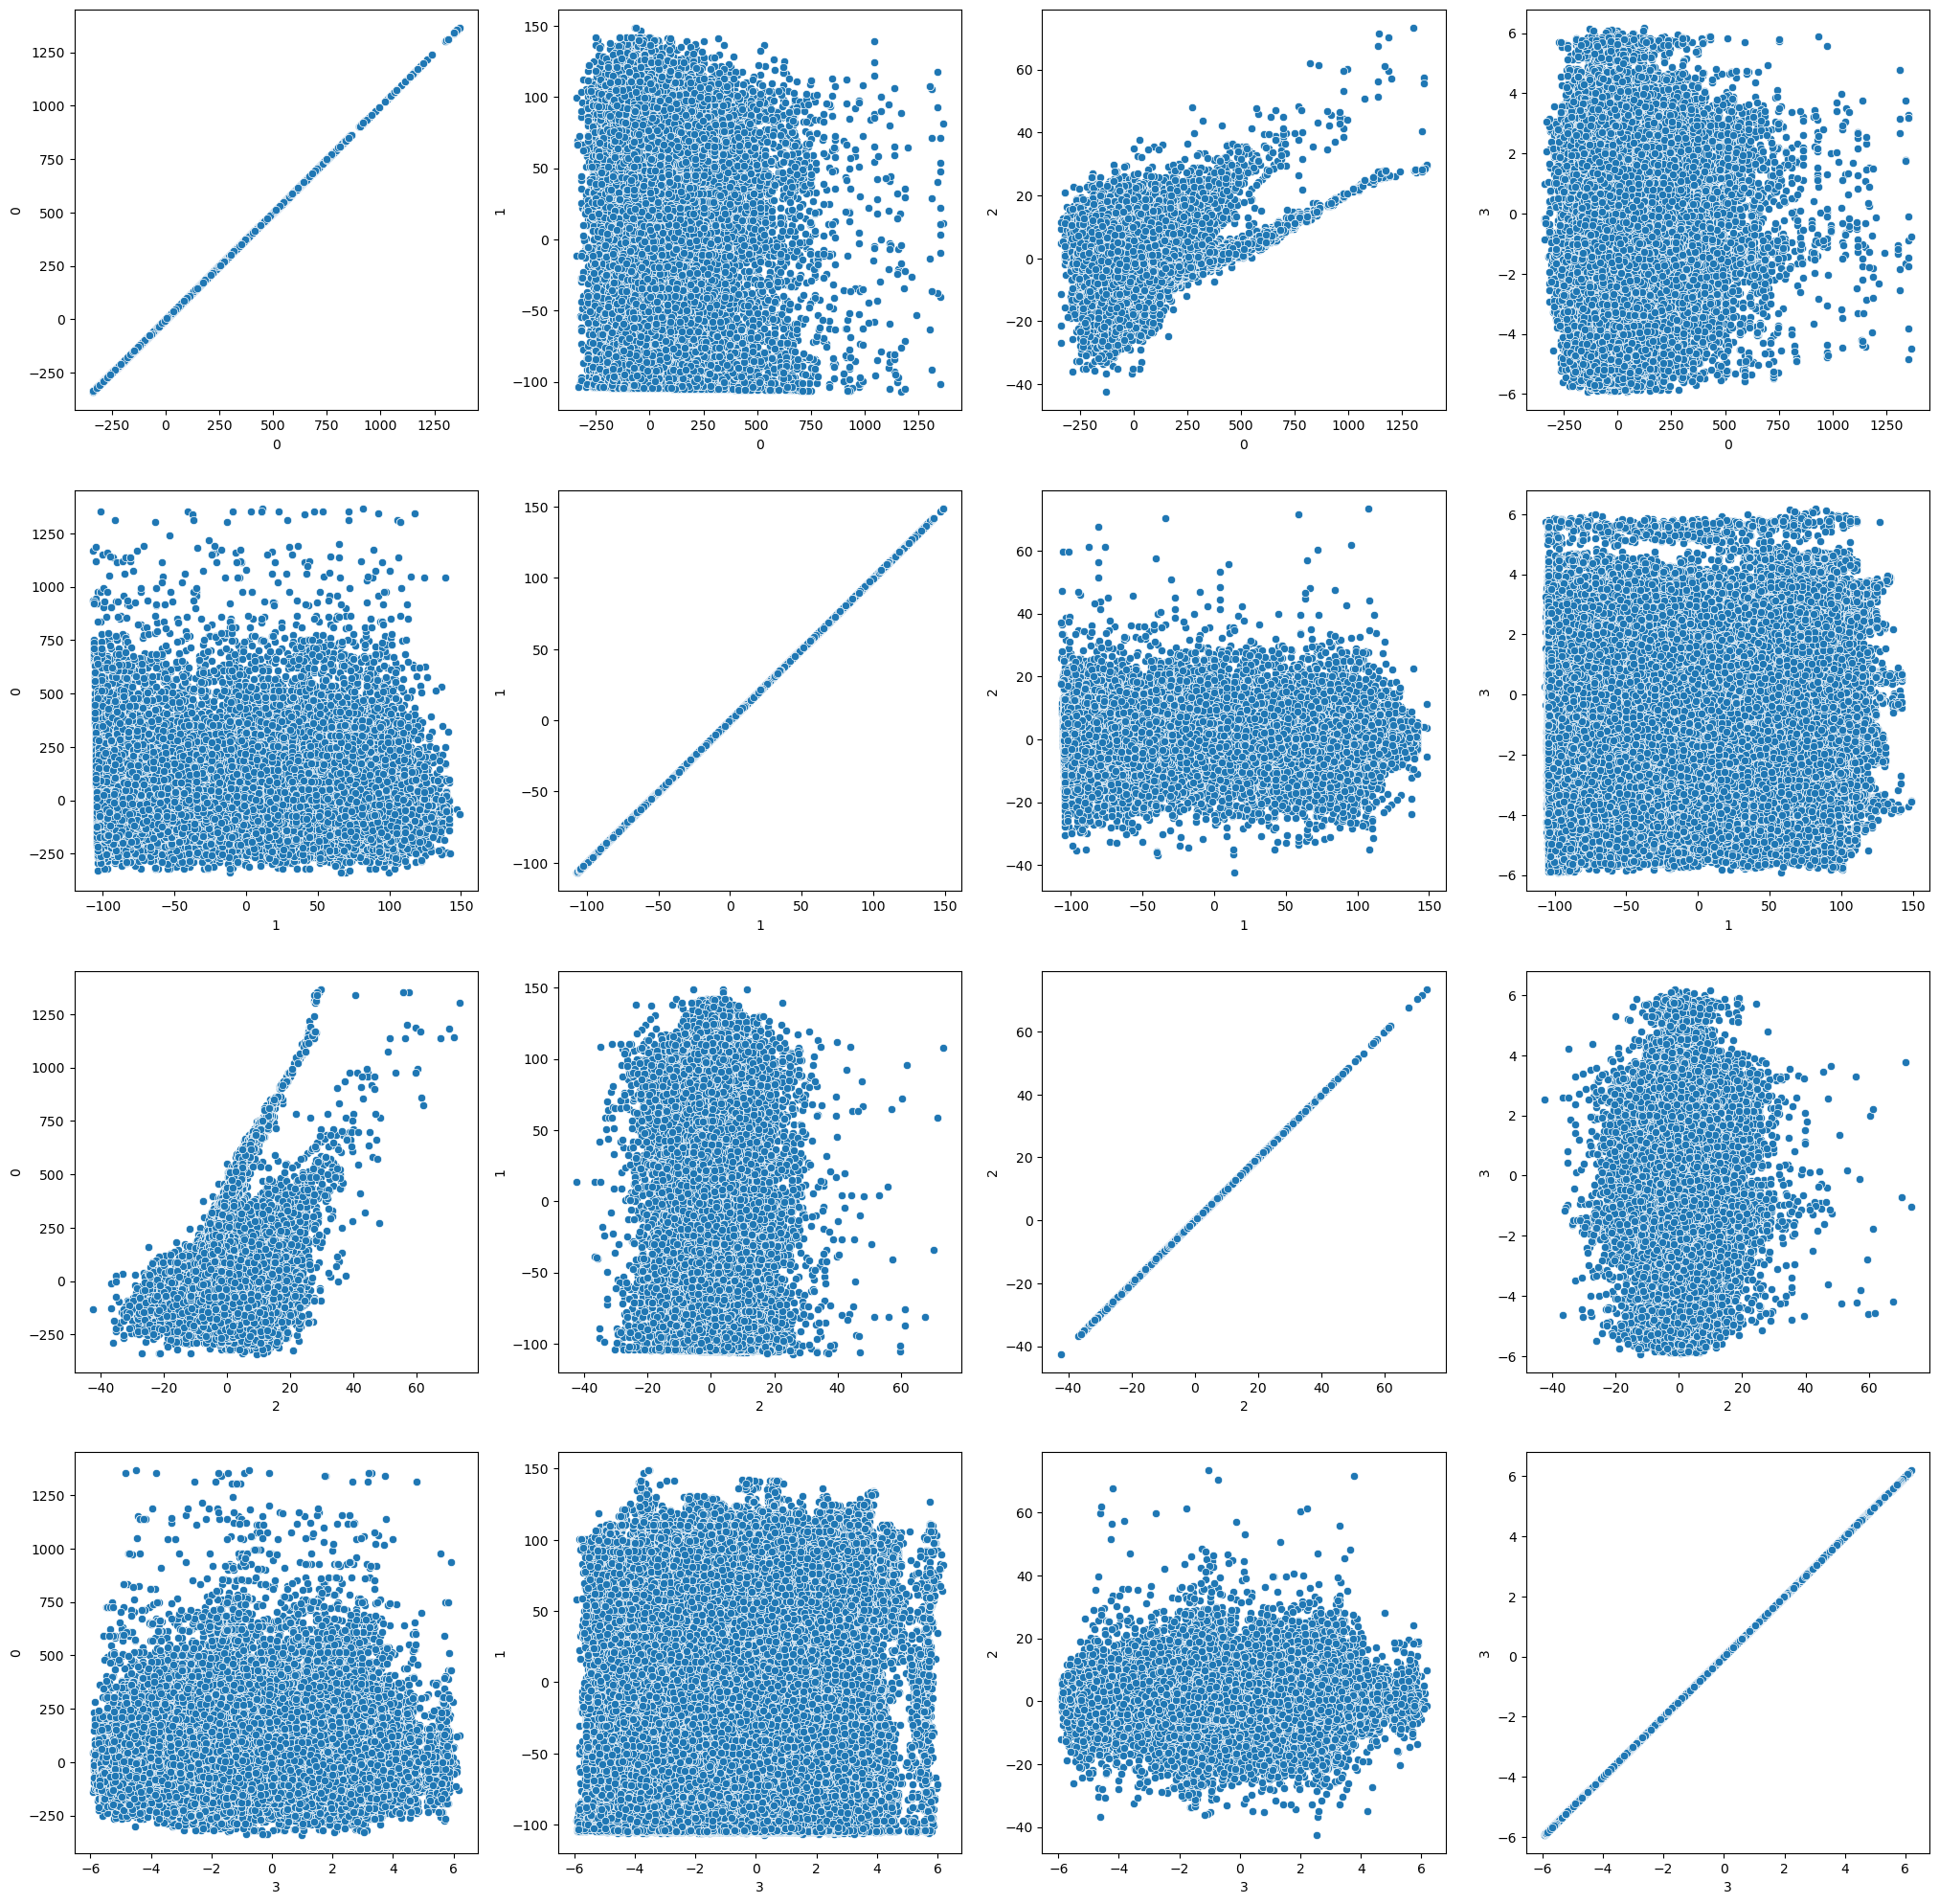

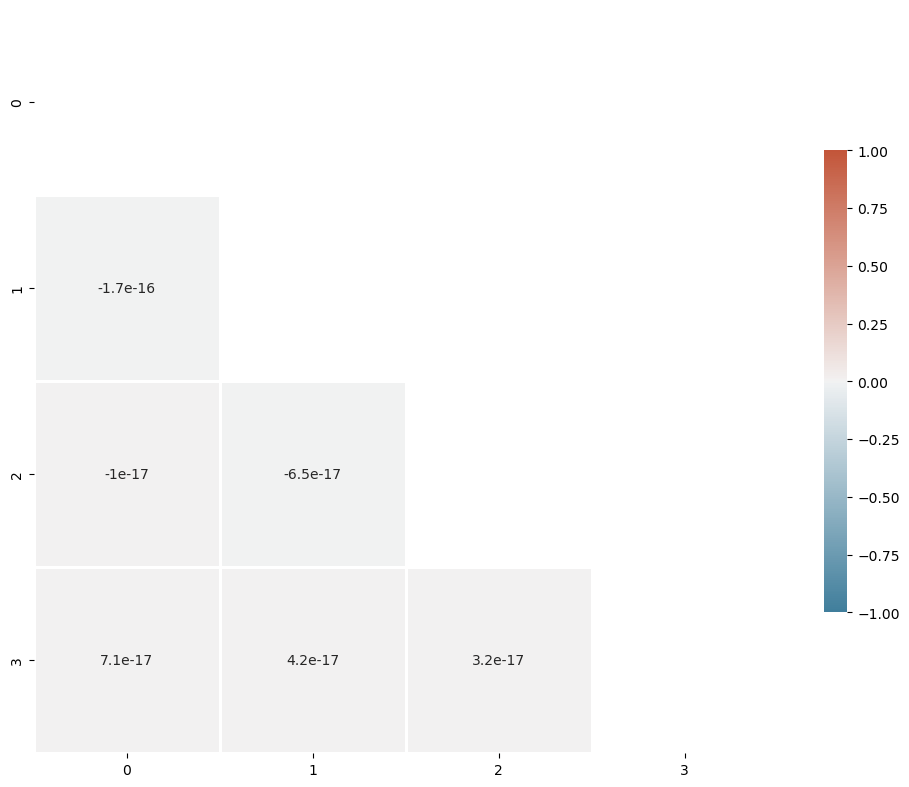

In [9]:
from sklearn.decomposition import PCA

def perform_PCA(data):
    pca = PCA(n_components = 'mle')
    data_pca = pd.DataFrame(pca.fit_transform(data[num_cols]))
    plot_scatter(data_pca[data_pca.columns],data_pca.columns,None)
    plot_corr(data_pca)
    return data_pca
pca_train = perform_PCA(trans_train)

In [10]:
from sklearn.linear_model import RidgeClassifierCV

model = RidgeClassifierCV(alphas = [0.1,0.3,0.5])
pca_train.columns = pca_train.columns.astype(str)   
train_final = pd.concat([trans_train[['HDF','PWF','OSF','RNF','L','M','H']], pca_train], axis = 1)
model.fit(train_final,train[target_cols])
print(model.get_params())
model.score(train_final,train[target_cols])


{'alphas': [0.1, 0.3, 0.5], 'class_weight': None, 'cv': None, 'fit_intercept': True, 'scoring': None, 'store_cv_values': False}


0.9948178173262283

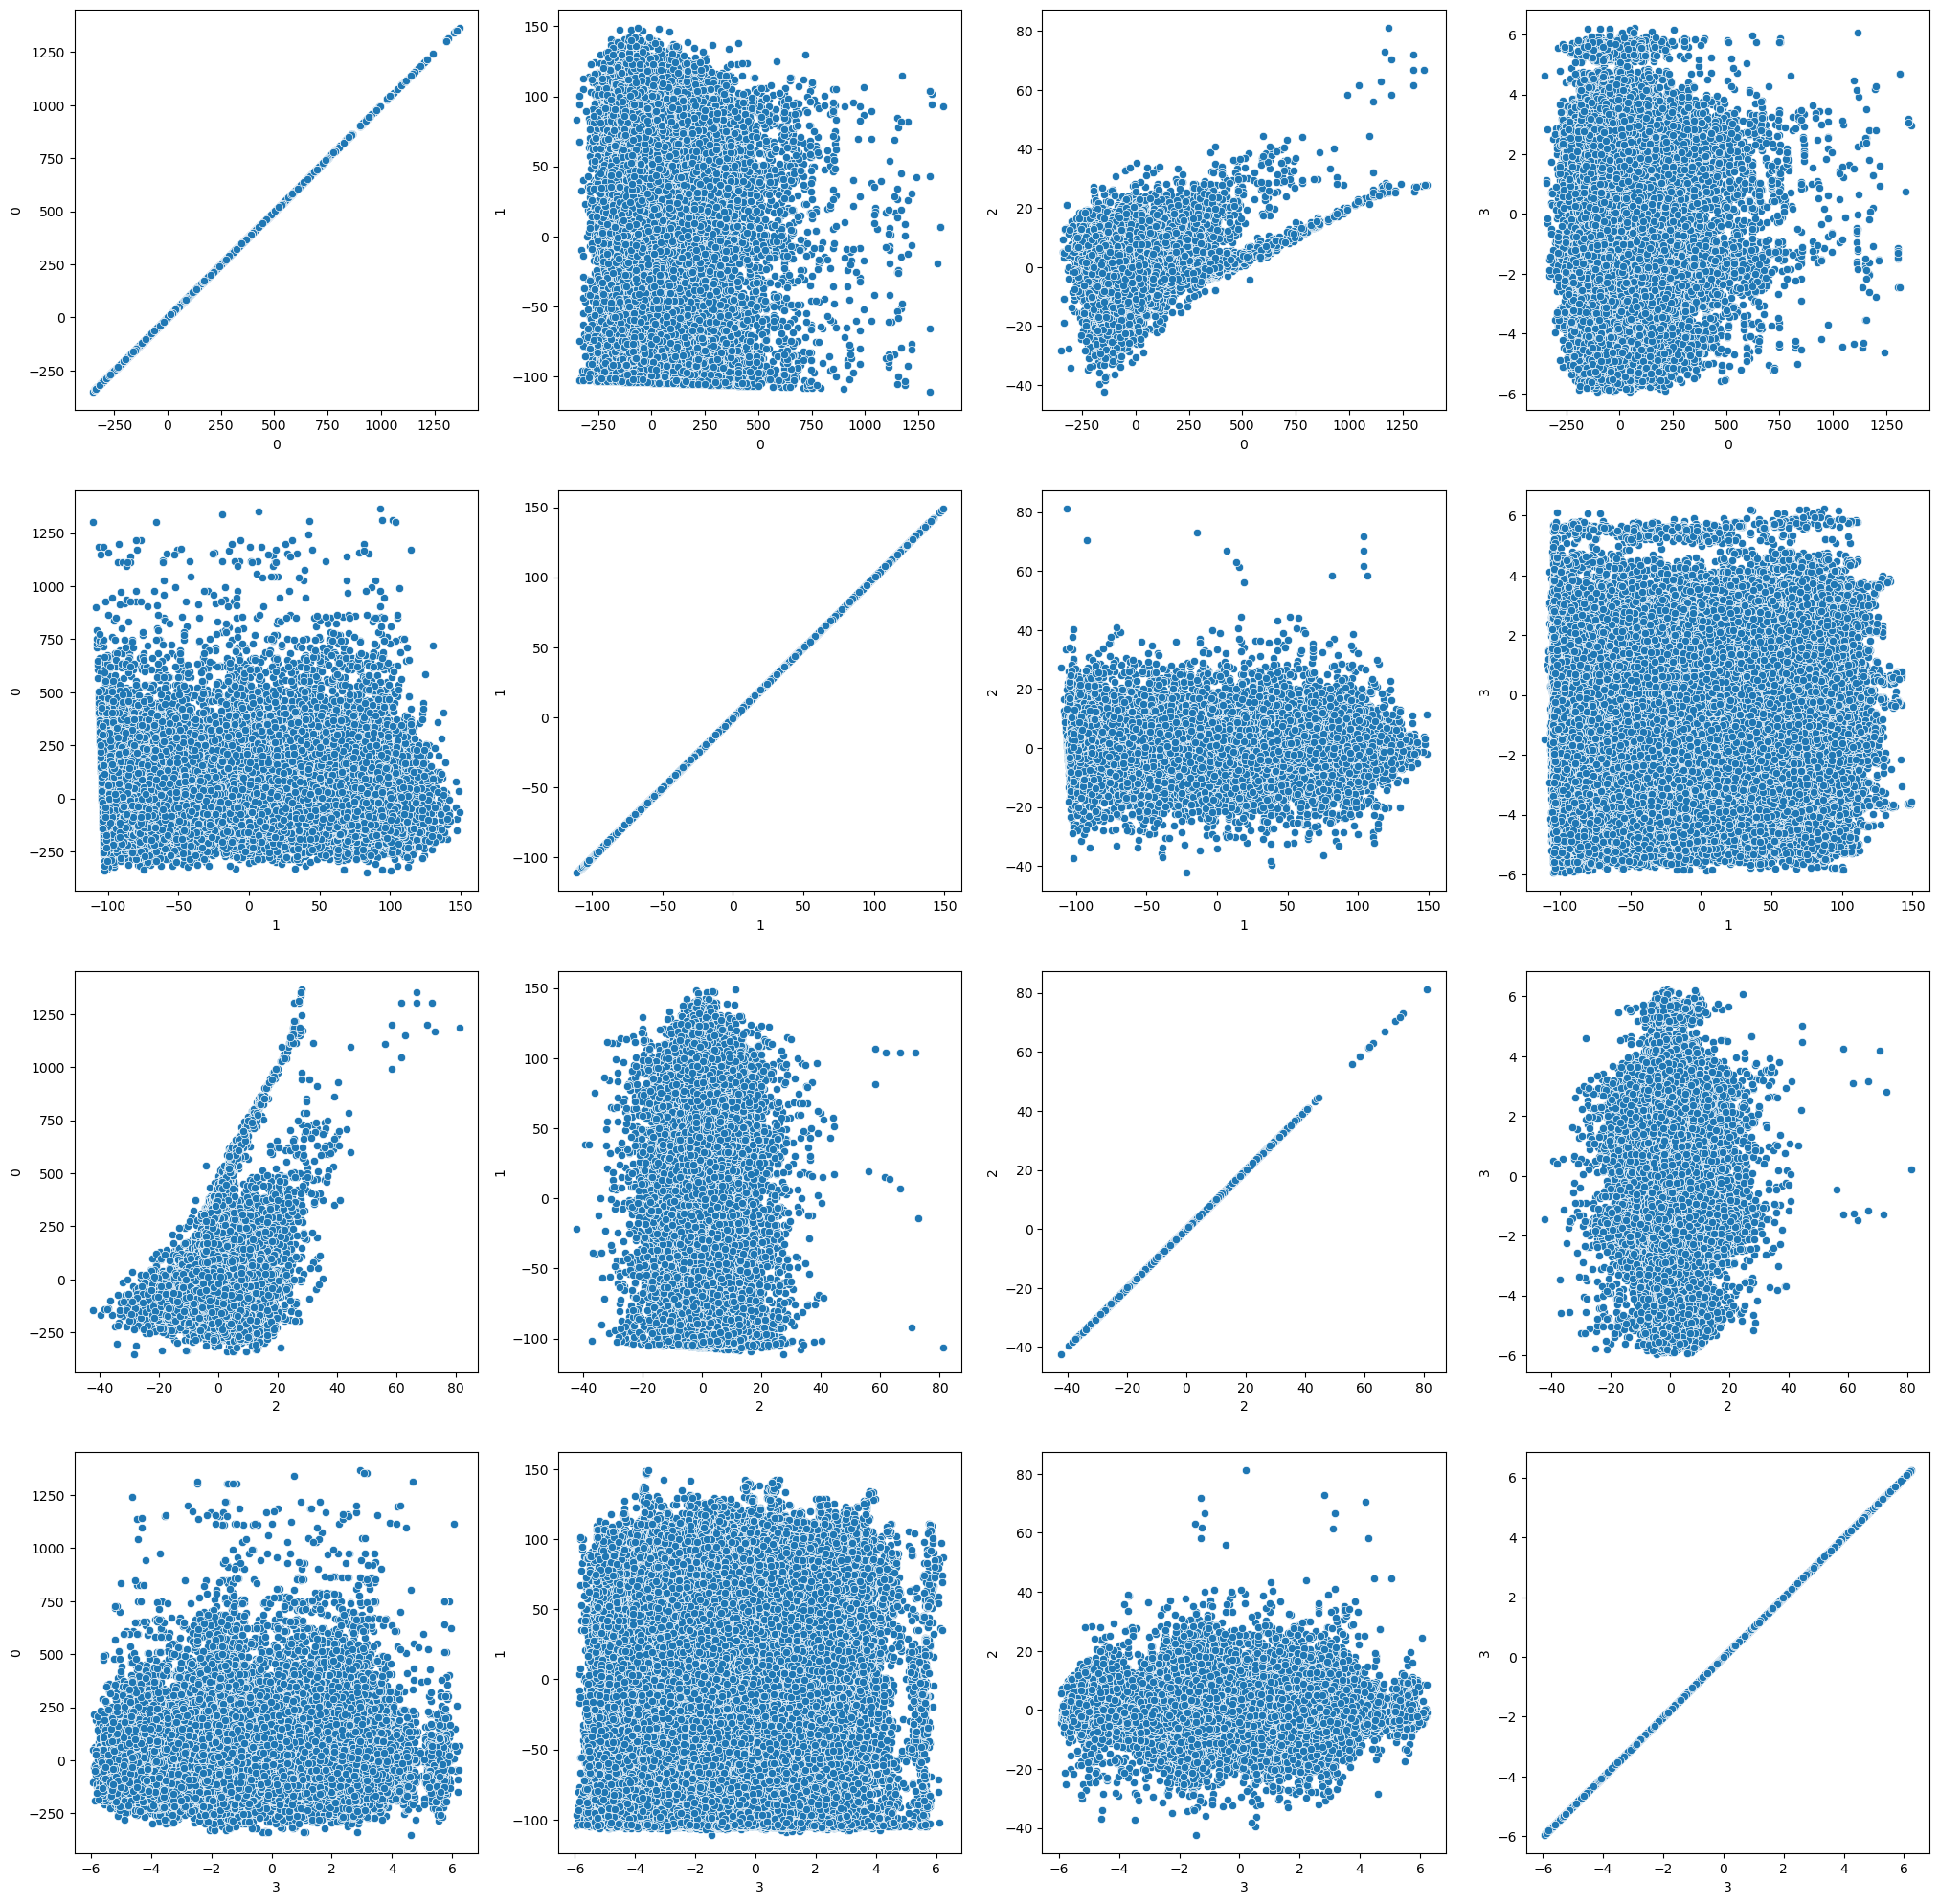

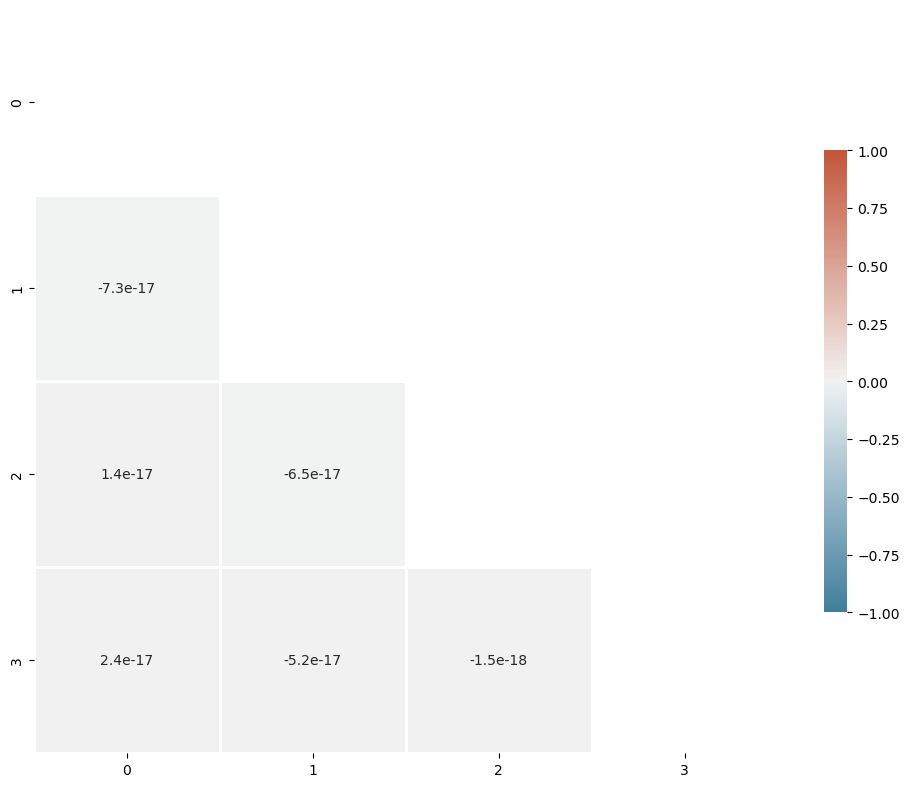

In [11]:
trans_test = one_hot_encode(test)
pca_test = perform_PCA(trans_test)

In [12]:
trans_test.columns = trans_test.columns.astype(str)
trans_test.columns = ['id', 'Product ID', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF', 'L', 'M', 'H']
pca_test.columns = pca_test.columns.astype(str)
final_test = pd.concat([trans_test[['HDF','PWF','OSF','RNF','L','M','H']], pca_test], axis = 1)
pred = model.predict(final_test)

In [13]:
pred = pd.DataFrame(pred)
submission = pd.concat([test['id'],pred],axis=1)

print(submission)

           id  0
0      136429  0
1      136430  0
2      136431  0
3      136432  0
4      136433  0
...       ... ..
90949  227378  0
90950  227379  0
90951  227380  0
90952  227381  0
90953  227382  0

[90954 rows x 2 columns]


In [14]:
submission.to_csv("Binary_Classification_of_Machine_Failures_submission_ridge.csv",index = False)